<a href="https://colab.research.google.com/github/Investigator13th/CS246/blob/main/CS246_homework2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark
!pip install -U -q PyDrive2
#the output 'xxx is not a symbolic link' will not affect your implementation or execution
#to fix 'xxx is not a symbolic link', you can comment out the lines starting from !mv xxxx
#you may need to replace xxx.11 with the correct version if other errors come up after colab update
#to get the correct version, use !ls /usr/local/lib to find out
!mv /usr/local/lib/libtbbmalloc_proxy.so.2 /usr/local/lib/libtbbmalloc_proxy.so.2.backup
!mv /usr/local/lib/libtbbmalloc.so.2 /usr/local/lib/libtbbmalloc.so.2.backup
!mv /usr/local/lib/libtbbbind_2_5.so.3 /usr/local/lib/libtbbbind_2_5.so.3.backup
!mv /usr/local/lib/libtbb.so.12 /usr/local/lib/libtbb.so.12.backup
!mv /usr/local/lib/libtbbbind_2_0.so.3 /usr/local/lib/libtbbbind_2_0.so.3.backup
!mv /usr/local/lib/libtbbbind.so.3 /usr/local/lib/libtbbbind.so.3.backup
!ln -s /usr/local/lib/libtbbmalloc_proxy.so.2.11 /usr/local/lib/libtbbmalloc_proxy.so.2
!ln -s /usr/local/lib/libtbbmalloc.so.2.11 /usr/local/lib/libtbbmalloc.so.2
!ln -s /usr/local/lib/libtbbbind_2_5.so.3.11 /usr/local/lib/libtbbbind_2_5.so.3
!ln -s /usr/local/lib/libtbb.so.12.11 /usr/local/lib/libtbb.so.12
!ln -s /usr/local/lib/libtbbbind_2_0.so.3.11 /usr/local/lib/libtbbbind_2_0.so.3
!ln -s /usr/local/lib/libtbbbind.so.3.11 /usr/local/lib/libtbbbind.so.3
# !sudo ldconfig
#If error related to the above execution occurs, you can try commenting out the above 12 lines under pip install PyDrive2 (not included)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#the output 'xxx is not a symbolic link' will not affect your implementation or execution
#to fix 'xxx is not a symbolic link', you can comment out the lines starting from !mv xxxx
#you may need to replace xxx.11 with the correct version if other errors come up after colab update
#to get the correct version, use !ls /usr/local/lib to find out

openjdk-8-jdk-headless is already the newest version (8u412-ga-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
from pyspark.sql import *

import pyspark.sql.functions as F
from pyspark import SparkContext
import pandas as pd
import numpy as np
# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

2-2的作业是用spark进行k-means聚类

In [42]:
def load_data(filename):
    """加载数据"""
    return sc.textFile(filename).map(lambda line: np.array([float(x) for x in line.split()]))

def load_centers(filename):
    """加载初始簇中心"""
    return [np.array([float(x) for x in line.split()]) for line in open(filename).readlines()]

def closest_center(point, centers):
    """找到离point最近的簇中心"""
    return min(enumerate(centers), key=lambda x: np.linalg.norm(point - x[1]))[0]

def update_center(aggregated_data):
    """更新簇中心"""
    sum_of_points, total_count = aggregated_data

    new_center = tuple(coord / total_count for coord in sum_of_points)

    return new_center

In [5]:
# 加载数据和初始簇中心
data = load_data('/content/drive/MyDrive/hw2-bundle/q2/data/data.txt')
c1_centers = load_centers('/content/drive/MyDrive/hw2-bundle/q2/data/c1.txt')
c2_centers = load_centers('/content/drive/MyDrive/hw2-bundle/q2/data/c2.txt')

Starting KMeans with initialization c1
Iteration 1, loss: 623660345.3064115
Iteration 2, loss: 509862908.2975454
Iteration 3, loss: 485480681.8720084
Iteration 4, loss: 463997011.68501294
Iteration 5, loss: 460969266.57299685
Iteration 6, loss: 460537847.9827684
Iteration 7, loss: 460313099.6535447
Iteration 8, loss: 460003523.8894082
Iteration 9, loss: 459570539.31773525
Iteration 10, loss: 459021103.3422909
Iteration 11, loss: 458490656.19198126
Iteration 12, loss: 457944232.5879751
Iteration 13, loss: 457558005.19867724
Iteration 14, loss: 457290136.35230196
Iteration 15, loss: 457050555.0595629
Iteration 16, loss: 456892235.6153559
Iteration 17, loss: 456703630.7370345
Iteration 18, loss: 456404203.01897514
Iteration 19, loss: 456177800.541994
Iteration 20, loss: 455986871.02734685
Starting KMeans with initialization c2
Iteration 1, loss: 438747790.02791756
Iteration 2, loss: 249803933.62600276
Iteration 3, loss: 194494814.40631253
Iteration 4, loss: 169804841.4515432
Iteration 5, 

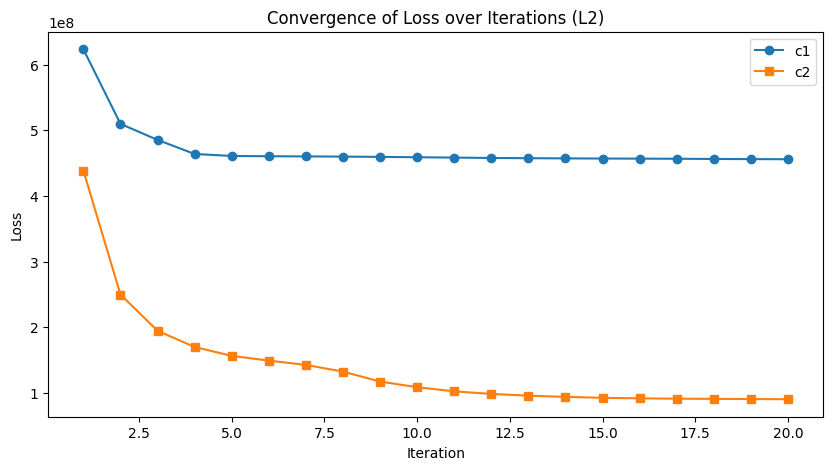

 the percentage change in cost of c1:26.48%
 the percentage change in cost of c2:76.70%


In [43]:
import matplotlib.pyplot as plt
# 设置迭代次数
num_iterations = 20
loss1 = []
loss2 = []
# 执行KMeans算法
for init_centers, name in [(c1_centers, 'c1'), (c2_centers, 'c2')]:
    centers = init_centers

    print(f"Starting KMeans with initialization {name}")

    for i in range(num_iterations):
        # 分配每个点到最近的簇中心
        assigned_points = data.map(lambda point: (closest_center(point, centers), (point, 1)))
        # (centriod, (point, 1))

        # 计算损失
        loss = assigned_points.map(lambda x: np.linalg.norm(x[1][0] - centers[x[0]])**2).reduce(lambda a, b: a + b)

        if name == 'c1':
          loss1.append(loss)
        else:
          loss2.append(loss)

        # 使用 reduceByKey 来聚合所有属于同一簇的点
        aggregated_points = assigned_points.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
        # (centriod, (sum_vector, count))

        # 更新簇中心
        new_centers = aggregated_points.mapValues(update_center).collectAsMap()
        # (centriod: (centriod_vector))

        # 新簇中心列表
        centers = [new_centers[i] for i in range(len(centers))]

        print(f"Iteration {i+1}, loss: {loss}")


# 绘制损失折线图
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss1) + 1), loss1, label='c1', marker='o')
plt.plot(range(1, len(loss2) + 1), loss2, label='c2', marker='s')
plt.title('Convergence of Loss over Iterations (L2)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f" the percentage change in cost of c1:{(loss1[0]-loss1[10])/loss1[0]*100:.2f}%")
print(f" the percentage change in cost of c2:{(loss2[0]-loss2[10])/loss2[0]*100:.2f}%")

In [44]:
def load_data(filename):
    """加载数据"""
    return sc.textFile(filename).map(lambda line: np.array([float(x) for x in line.split()]))

def load_centers(filename):
    """加载初始簇中心"""
    return [np.array([float(x) for x in line.split()]) for line in open(filename).readlines()]

def closest_center(point, centers):
    """找到离point最近的簇中心  L1"""
    return min(enumerate(centers), key=lambda x: np.linalg.norm(point - x[1], ord=1))[0]

def update_center(aggregated_data):
    """更新簇中心"""
    sum_of_points, total_count = aggregated_data

    new_center = tuple(coord / total_count for coord in sum_of_points)

    return new_center

Starting KMeans with initialization c1
Iteration 1, loss: 550117.1419999995
Iteration 2, loss: 464829.2684039448
Iteration 3, loss: 470934.15384668094
Iteration 4, loss: 483874.81628509343
Iteration 5, loss: 489234.2347883463
Iteration 6, loss: 487664.6926267904
Iteration 7, loss: 483718.6659285149
Iteration 8, loss: 475337.9476330566
Iteration 9, loss: 474871.96654965664
Iteration 10, loss: 457244.7897417528
Iteration 11, loss: 447493.1956040521
Iteration 12, loss: 450891.8358047706
Iteration 13, loss: 451232.57747569657
Iteration 14, loss: 451860.12588546576
Iteration 15, loss: 451567.2235891488
Iteration 16, loss: 452710.05209994374
Iteration 17, loss: 453078.22696184996
Iteration 18, loss: 450646.1355620941
Iteration 19, loss: 450419.9701134367
Iteration 20, loss: 449009.59037188545
Starting KMeans with initialization c2
Iteration 1, loss: 1433739.3099999954
Iteration 2, loss: 1084488.7769648773
Iteration 3, loss: 973431.7146620404
Iteration 4, loss: 895934.5925630709
Iteration 5, 

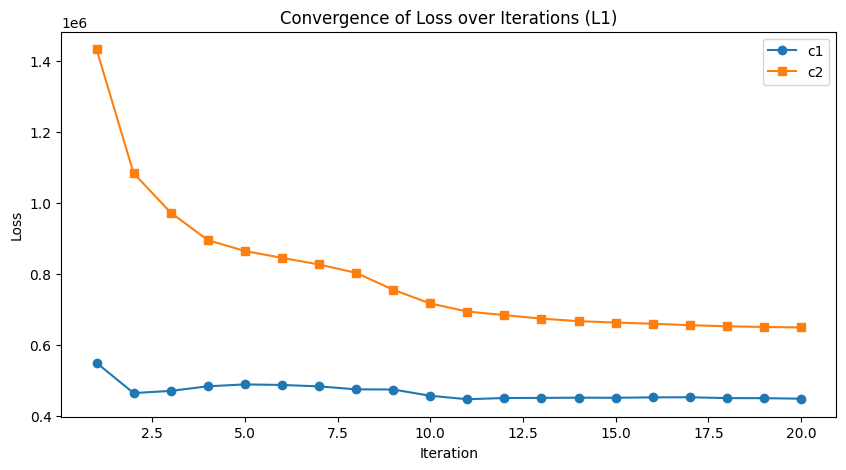

 the percentage change in cost of c1:18.65%
 the percentage change in cost of c2:51.55%


In [45]:
import matplotlib.pyplot as plt
# 设置迭代次数
num_iterations = 20
loss1 = []
loss2 = []
# 执行KMeans算法
for init_centers, name in [(c1_centers, 'c1'), (c2_centers, 'c2')]:
    centers = init_centers

    print(f"Starting KMeans with initialization {name}")

    for i in range(num_iterations):
        # 分配每个点到最近的簇中心
        assigned_points = data.map(lambda point: (closest_center(point, centers), (point, 1)))
        # (centriod, (point, 1))

        # 计算损失
        loss = assigned_points.map(lambda x: np.linalg.norm(x[1][0] - centers[x[0]], ord=1)).reduce(lambda a, b: a + b)

        if name == 'c1':
          loss1.append(loss)
        else:
          loss2.append(loss)

        # 使用 reduceByKey 来聚合所有属于同一簇的点
        aggregated_points = assigned_points.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
        # (centriod, (sum_vector, count))

        # 更新簇中心
        new_centers = aggregated_points.mapValues(update_center).collectAsMap()
        # (centriod: (centriod_vector))

        # 新簇中心列表
        centers = [new_centers[i] for i in range(len(centers))]

        print(f"Iteration {i+1}, loss: {loss}")


# 绘制损失折线图
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss1) + 1), loss1, label='c1', marker='o')
plt.plot(range(1, len(loss2) + 1), loss2, label='c2', marker='s')
plt.title('Convergence of Loss over Iterations (L1)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f" the percentage change in cost of c1:{(loss1[0]-loss1[10])/loss1[0]*100:.2f}%")
print(f" the percentage change in cost of c2:{(loss2[0]-loss2[10])/loss2[0]*100:.2f}%")